# Clustering Data Science
I Wayan Angga Kusuma Yoga <br>
950159

## Load Libraries

In [1]:
import ibm_db
import ibm_db_sa
import sqlalchemy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
import os
warnings.filterwarnings("ignore")

py.offline.init_notebook_mode(connected = True)

## Connect to the Database

sebelumnya telah dilakukan perubahan data secara manual karena ada anomali tanggal yang salah dari 29 Februari menjadi 28 Februari, lalu data dimasukkan ke dalam DB2 dan dihubungkan ke jupyter notebook.

In [2]:
credentials = "ibm_db_sa://rrl04760:SO1vbtUCtrd4VAZY@54a2f15b-5c0f-46df-8954-7e38e612c2bd.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:32733/BLUDB?security=SSL"

## Data Exploration

karena menggunakan RFM Analysis, maka data harus dipersiapkan terlebih dahulu dengan membuat variabel recency, frequency, dan monetary dengan query SQL sebagai berikut.

In [3]:
sql_df = pd.read_sql_query('''
select
    TR.CUSTOMER_ID,
    case
        when TR.MAX_DATE is null then 0
        else days(current_date) - days(TR.MAX_DATE)
        end as RECENCY,
    TR.FREQUENCY,
    TR.MONETARY
from
    (select CUSTOMER_ID, max(TRANS_DATE) as MAX_DATE, count(TRANS_DATE) as FREQUENCY, sum(TRANS_AMOUNT) as MONETARY
    from TRANSACTIONS
    group by CUSTOMER_ID) as TR
order by TR.CUSTOMER_ID''', con = credentials)

In [24]:
sql_df.head()

,customer_id,recency,frequency,monetary
0,CS1112,603,15,1012
1,CS1113,577,20,1490
2,CS1114,574,19,1432
3,CS1115,552,22,1659
4,CS1116,745,13,857


In [5]:
sql_df.shape

(6889, 4)

In [6]:
sql_df.describe()

,recency,frequency,monetary
count,6889.000000,6889.000000,6889.000000
mean,622.349252,18.144869,1179.269705
std,85.545443,5.193014,465.832609
min,541.000000,4.000000,149.000000
25%,564.000000,14.000000,781.000000
50%,595.000000,18.000000,1227.000000
75%,653.000000,22.000000,1520.000000
max,1399.000000,39.000000,2933.000000


## Data Visualization

In [7]:
plt.style.use('seaborn')

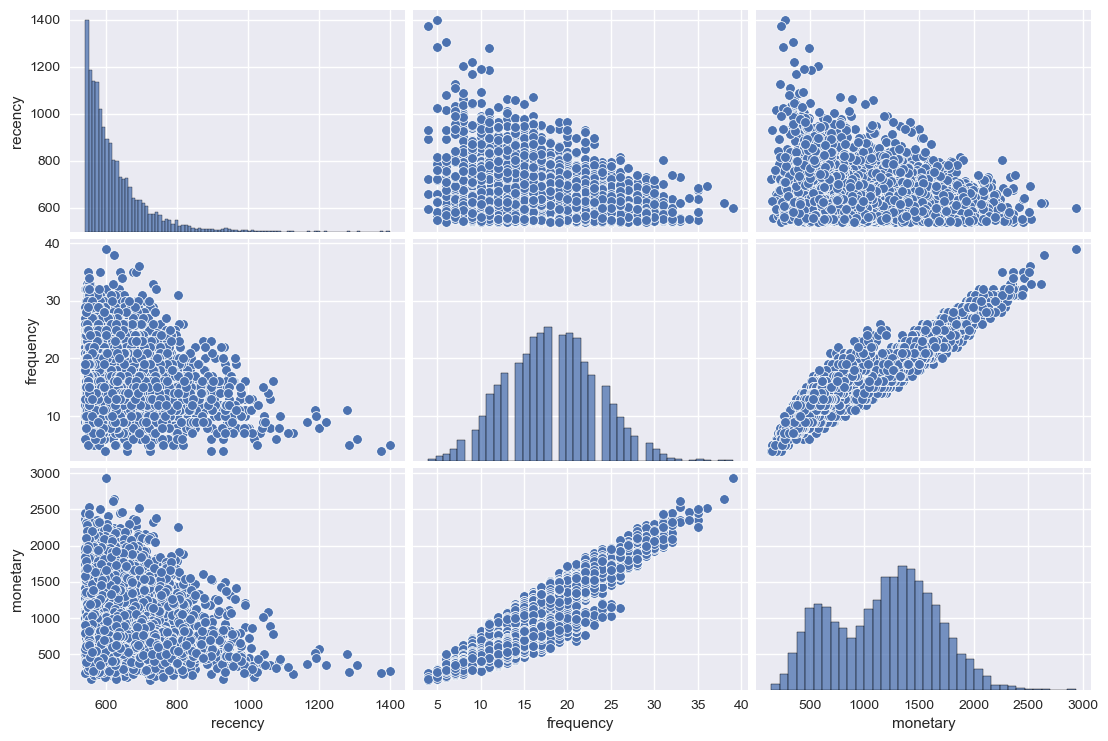

In [8]:
sns.pairplot(sql_df.drop('customer_id', axis=1), aspect=1.5)
plt.show()

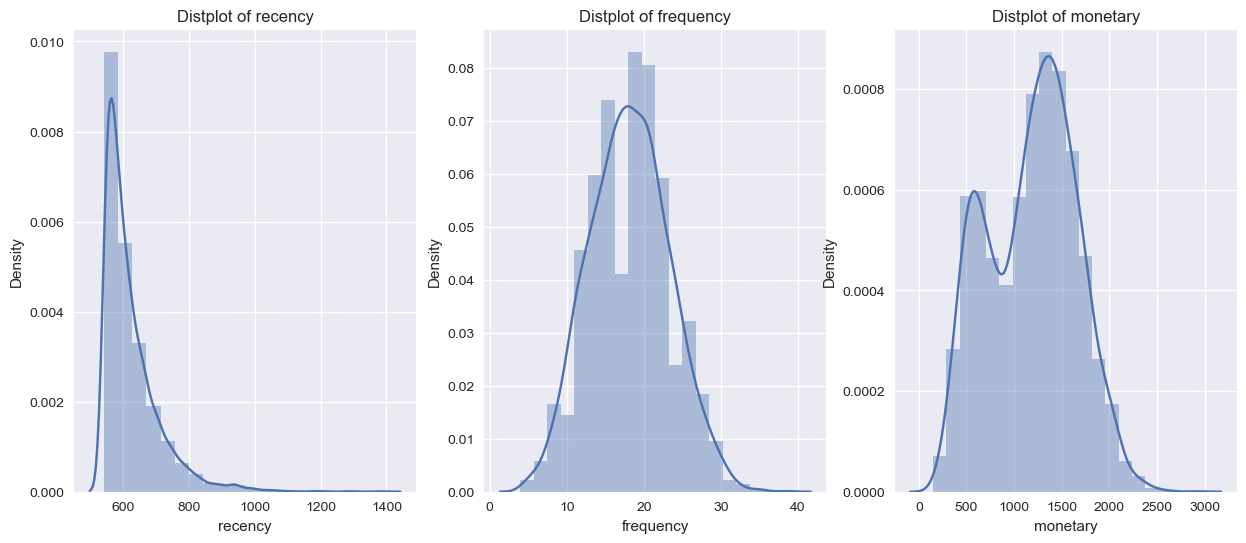

In [9]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['recency' , 'frequency' , 'monetary']:
    n += 1
    plt.subplot(1 , 3 , n)
    sns.distplot(sql_df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

## Standardized Variable

In [10]:
X = sql_df.drop(['customer_id'], axis=1)

standardize = StandardScaler()
X_std = pd.DataFrame(standardize.fit_transform(X))
X_std.columns = X.columns

In [11]:
X_std.head()

,recency,frequency,monetary
0,-0.226203,-0.605640,-0.359103
1,-0.530157,0.357262,0.667091
2,-0.565229,0.164682,0.542574
3,-0.822421,0.742423,1.029909
4,1.433854,-0.990801,-0.691865


## K-Means: 3 Variables (R, F, M) with Elbow Method and Silhouette to Determine k

In [12]:
def k_means_inertia_silhouette(X, k_max = 10, init = 'k-means++'):
    inertia = []
    silhouette = []
    for k in range(2, k_max):
        km =  KMeans(init = init, n_clusters = k, random_state= 123)
        km.fit(X)
        inertia.append(km.inertia_)
        silhouette.append(silhouette_score(X, km.labels_))
    
    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , inertia , 'o')
    plt.plot(np.arange(2 , k_max) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.title('The Elbow method using Inertia for each number of cluster')
    plt.show()

    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , silhouette , 'o')
    plt.plot(np.arange(2 , k_max) , silhouette , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette')
    plt.title('Silhouette score for each number of cluster')
    plt.show()
    
    return inertia, silhouette

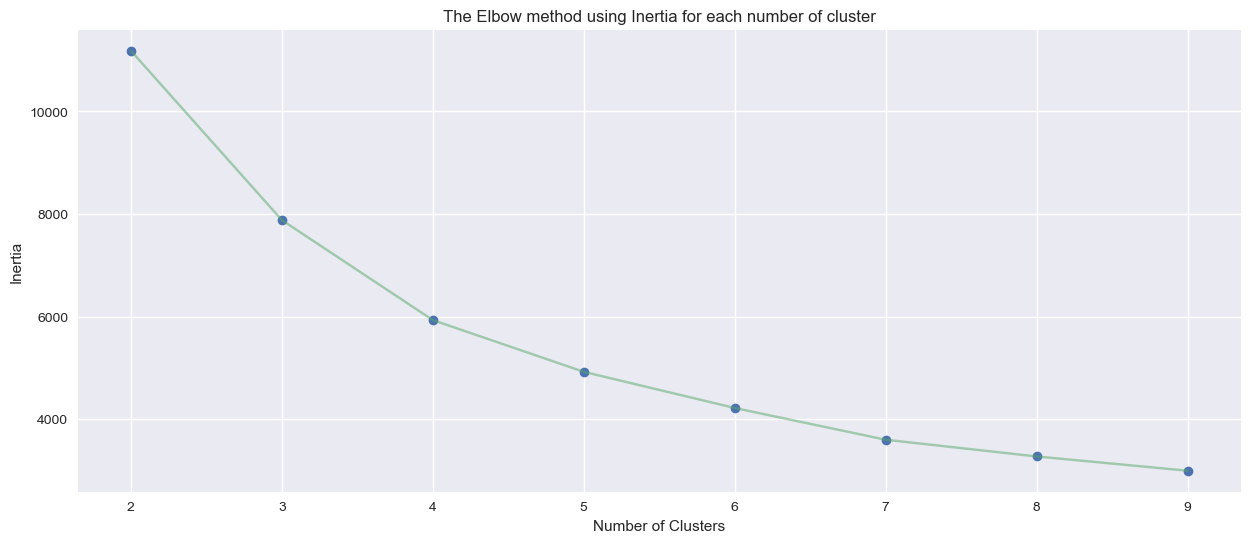

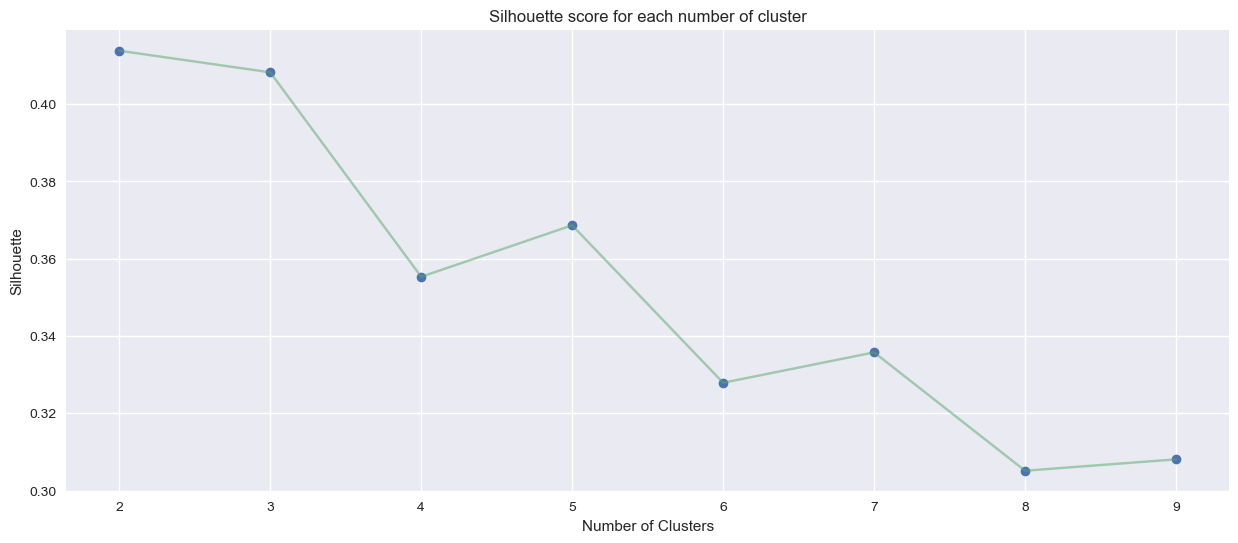

In [13]:
inertia, silhouette = k_means_inertia_silhouette(X_std, k_max = 10, init = 'k-means++')

berdasarkan elbhow method, kita simpulkan jumlah cluster (k) adalah 5

In [17]:
k = 5
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(X_std)

KMeans(n_clusters=5, random_state=123)

In [18]:
Segment = k_means.labels_
X.groupby(Segment, as_index=False).mean()

,recency,frequency,monetary
0,706.118681,18.705495,1271.380220
1,580.077471,18.621995,1262.236420
2,587.535463,24.998083,1768.491374
3,608.565767,12.660540,635.299253
4,849.967213,11.683841,604.929742


## Data Visualization

In [19]:
X['Segment'] = list(map(str, Segment))
fig = px.scatter_3d(X, x='recency', y='frequency', z='monetary', color='Segment',
                   opacity = 0.8, height=800)
fig.show() # to show as static image: fig.show('svg') 

berikut detail masing-masing cluster

In [21]:
X.groupby('Segment').agg({
    'recency':['mean','min','max'],
    'frequency':['mean','min','max'],
    'monetary':['mean','min','max']
})

recency             frequency             monetary            
               mean  min   max       mean min max         mean   min   max
Segment                                                                   
0        706.118681  643   931  18.705495  13  27  1271.380220   656  1905
1        580.077471  541   643  18.621995  14  25  1262.236420   670  1712
2        587.535463  541   801  24.998083  21  39  1768.491374  1348  2933
3        608.565767  541   731  12.660540   4  18   635.299253   157  1092
4        849.967213  723  1399  11.683841   4  22   604.929742   149  1498

## Clustering Analysis

Berdasarkan clustering menggunakan metode K-Means, dengan visualisasi dari scatter plot, didapatkan 5 cluster dengan detail sebagai berikut:

| Segment      | Penjelasan    | Label |
| ------------ | ------------- | ----- |
| 0 | pelanggan sudah lama tidak melakukan transaksi (rata-rata rentang recency jauh = 706) namun terhitung masih sering melakukan pembelian (rata-rata frequency besar = 18), dan total uang yang dikeluarkan selama bertransaksi cukup banyak (rata-rata monetary sedang = 1271), pelanggan ini potensial namun sangat berisiko untuk tidak melakukan transaksi lagi | 'At Risk of Leaving' Customers |
| 1 | pelanggan baru-baru ini melakukan transaksi (rata-rata rentang recency pendek = 587) dan terhitung masih sering melakukan pembelian (rata-rata frequency besar = 18), serta total uang yang dikeluarkan selama bertransaksi cukup banyak (rata-rata monetary sedang = 1262), cluster ini berisi pelanggan yang potensial namun masih berada di bawah 'Top Class' Customers | Loyal Customers |
| 2 | pelanggan baru-baru ini melakukan transaksi (rata-rata rentang recency pendek = 608) dan juga sering sekali melakukan pembelian (rata-rata frequency besar = 24), serta total uang yang dikeluarkan selama bertransaksi paling banyak (rata-rata monetary besar = 1768), cluster ini yang paling menguntungkan perusahaan | 'Top Class' Customers |
| 3 | pelanggan baru-baru ini melakukan transaksi (rata-rata rentang recency pendek = 608), namun jarang melakukan pembelian (rata-rata frequency kecil = 12), dan total uang yang dikeluarkan selama bertransaksi juga sedikit (rata-rata monetary kecil = 635), cluster ini masih memiliki potensi karena baru-baru ini masih bertransaksi | New Customers |
| 4 | pelanggan sudah lama tidak melakukan transaksi (rata-rata rentang recency jauh = 849), jarang melakukan pembelian (rata-rata frequency kecil = 11), dan total uang yang dikeluarkan selama bertransaksi juga sedikit (rata-rata monetary kecil = 604), bisa kita anggap cluster ini paling tidak menguntungkan untuk perusahaan | Lost Customers |

## Clustering Data Mapping

In [26]:
sql_df['clustering'] = pd.Series(Segment, index=sql_df.index)
sql_df.head()

,customer_id,recency,frequency,monetary,clustering
0,CS1112,603,15,1012,1
1,CS1113,577,20,1490,1
2,CS1114,574,19,1432,1
3,CS1115,552,22,1659,2
4,CS1116,745,13,857,4


In [40]:
sql_df.loc[sql_df['clustering'] == 0,'segment'] = 'At Risk of Leaving Customers'
sql_df.loc[sql_df['clustering'] == 1,'segment'] = 'Loyal Customers'
sql_df.loc[sql_df['clustering'] == 2,'segment'] = 'Top Class Customers'
sql_df.loc[sql_df['clustering'] == 3,'segment'] = 'New Customers'
sql_df.loc[sql_df['clustering'] == 4,'segment'] = 'Lost Customers'
sql_df.head(10)

,customer_id,recency,frequency,monetary,clustering,segment
0,CS1112,603,15,1012,1,Loyal Customers
1,CS1113,577,20,1490,1,Loyal Customers
2,CS1114,574,19,1432,1,Loyal Customers
3,CS1115,552,22,1659,2,Top Class Customers
4,CS1116,745,13,857,4,Lost Customers
5,CS1117,799,17,1185,0,At Risk of Leaving Customers
6,CS1118,543,15,1011,1,Loyal Customers
7,CS1119,552,15,1158,1,Loyal Customers
8,CS1120,551,24,1677,2,Top Class Customers
9,CS1121,583,26,1524,2,Top Class Customers
